# Comparing clustering algorithms

This notebook aims to answer an overarching questions describing FLASC's behavior:

1. How does FLASC's branch-detection ability compare to other clustering
   algorithms in terms of accuracy and stability?

We compare the algorithms (using tuned parameter settings) on a synthetic
dataset in which clusters have branches and for which we have ground-truth
branch-membership information. We measure the adjusted rand index (ARI) between
the ground-truth and their detected subgroups to describe how well the
algorithms segmented the points into the true branch-based subgroups. We measure
how much the detected sub-group centroids move between repeated runs to describe
the algorithm's stability (across runs).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

# Avoid multi-threading
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

In [3]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lib.plotting import *
%matplotlib inline
configure_matplotlib()

from tqdm import tqdm
from itertools import product
from collections import defaultdict

from scipy import linalg
from sklearn.utils import shuffle
from sklearn.metrics.cluster import adjusted_rand_score

from lib.cdc import CDC
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from flasc import FLASC
from flasc.prediction import (
    branch_centrality_vectors,
    update_labels_with_branch_centrality,
)

## Dataset generation

- Generate multiple star-like clusters spread in 2D space.
- Exponentially spaced points along the branches make density maxima within them unlikely.
- Gaussian noise is added in a varying number of dimensions >= 2.
- Number of points in each branch is varied.
- Uniformly spread noise points are added and given a single target label (num noise points = num points // 20).

In [4]:
def make_star(
    num_dimensions=2,
    num_branches=3,
    points_per_branch=100,
    branch_length=2,
    noise_scale=0.02,
):
    """Creates a n-star in d dimensions."""

    def rotation(axis=[0, 0, 1], theta=0):
        return linalg.expm(np.cross(np.eye(3), axis / linalg.norm(axis) * theta))

    def rotate(X, axis=[0, 0, 1], theta=0):
        M = rotation(axis=axis, theta=theta)
        data = np.hstack((X, np.zeros((X.shape[0], 1), dtype=X.dtype)))
        return (M @ data.T).T[:, :2]

    max_exp = np.log(branch_length)
    branch = np.zeros((points_per_branch, 2))
    branch[:, 0] = np.exp(np.linspace(0, max_exp, points_per_branch)) - 1
    branches = np.concatenate(
        [
            rotate(branch, theta=theta)
            for theta in np.linspace(0, 2 * np.pi, num_branches, endpoint=False)
            + np.pi / 2
        ]
    )
    X = np.column_stack((branches, np.zeros((branches.shape[0], num_dimensions - 2))))
    X += np.random.normal(
        scale=np.sqrt(1 / num_dimensions) * noise_scale,
        size=X.shape,
    )
    y = np.repeat(np.arange(num_branches), points_per_branch)
    return X, y


def make_stars_dataset(size_factor=1, num_dimensions=2):
    num_branches = [3, 10, 4, 5]
    branch_lengths = [1.8, 3.5, 2.3, 2]
    points_per_branch = [40, 100, 150, 20]
    noise_scales = [0.2, 0.1, 0.2, 0.02]
    origins = np.array(
        [
            [7, 1],
            [2, 3],
            [5.5, 3],
            [7, 5],
        ]
    )

    # Make individual starts
    Xs, ys = zip(
        *[
            make_star(
                num_dimensions=num_dimensions,
                num_branches=nb,
                branch_length=l,
                points_per_branch=int(np * size_factor),
                noise_scale=s,
            )
            for l, np, nb, s in zip(
                branch_lengths, points_per_branch, num_branches, noise_scales
            )
        ]
    )

    # Concatenate to one dataset
    X = np.concatenate(
        [
            x + np.concatenate((o, np.zeros(num_dimensions - 2)))
            for x, o in zip(Xs, origins)
        ]
    )
    y = np.concatenate(
        [y + nb for y, nb in zip(ys, [0] + np.cumsum(num_branches).tolist())]
    )

    # Add uniform noise points
    num_noise_points = X.shape[0] // 20
    noise_points = np.random.uniform(
        low=X.min(axis=0), high=X.max(axis=0), size=(num_noise_points, num_dimensions)
    )
    noise_labels = np.repeat(-1, num_noise_points)
    X = np.concatenate((X, noise_points))
    y = np.concatenate((y, noise_labels))

    # Shuffle the data
    return shuffle(X, y)

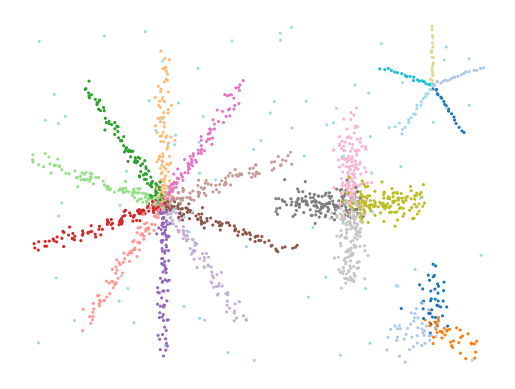

In [5]:
X, y = make_stars_dataset()
plot_kwargs = dict(s=5, cmap="tab20", vmin=0, vmax=19, edgecolors="k", linewidths=0)
plt.scatter(*X.T, c=y % 20, **plot_kwargs)
plt.axis("off")
plt.show()

## Parameter Sweep

A parameter grid-search is used to find the optimal parameters for each
algorithm. This ensures we are comparing the algorithms on their best
performance. Searching all parameter combinations for all algorithms creates a
too large search space. Instead we chose to keep some values at their defaults.
We tried to mimic realistic use of the algorithms when selecting which
parameters to keep at their default!

In [6]:
algorithms = dict(
    hdbscan=HDBSCAN,
    slink=AgglomerativeClustering,
    cdc=CDC,
    kmeans=KMeans,
    spectral=SpectralClustering,
    flasc=FLASC,
)
static_params = defaultdict(
    dict,
    slink=dict(linkage="single"),
    spectral=dict(assign_labels="cluster_qr", n_jobs=1),
    hdbscan=dict(core_dist_n_jobs=1),
    flasc=dict(num_jobs=1),
)

In [7]:
# Configure the parameter sweep
n_clusters = np.ceil(np.linspace(4, 27, 6)).astype(np.int32)
n_neighbors = np.round(np.linspace(2, 20, 6)).astype(np.int32)
min_cluster_sizes = np.unique(
    np.round(np.exp(np.linspace(np.log(20), np.log(100), 10)))
).astype(np.int32)
min_branch_sizes = np.unique(
    np.round(np.exp(np.linspace(np.log(3), np.log(50), 10)))
).astype(np.int32)
selection_methods = ["eom", "leaf"]

dynamic_params = dict(
    cdc=dict(k=n_neighbors, ratio=np.linspace(0.5, 0.95, 5).round(2)),
    kmeans=dict(n_clusters=n_clusters),
    slink=dict(n_clusters=n_clusters),
    spectral=dict(n_clusters=n_clusters),
    hdbscan=dict(
        min_samples=n_neighbors,
        min_cluster_size=min_cluster_sizes,
        cluster_selection_method=selection_methods,
    ),
    flasc=dict(
        min_samples=n_neighbors,
        min_cluster_size=min_cluster_sizes,
        min_branch_size=min_branch_sizes,
        cluster_selection_method=selection_methods,
        branch_detection_method=["full", "core"],
    ),
)

all_params = {name for params in dynamic_params.values() for name in params.keys()}

In [8]:
# Create output structure
results = {
    "repeat": [],
    "d": [],
    "alg": [],
    "ari": [],
    "labels": [],
    **{name: [] for name in all_params},
}

for r in tqdm(range(5)):
    for d in [2, 8, 16]:
        # Generate dataset
        X, y = make_stars_dataset(size_factor=1, num_dimensions=d)
        np.save(f"data/generated/star_parameter_sweep_X_{r}_{d}", X)
        np.save(f"data/generated/star_parameter_sweep_y_{r}_{d}", y)

        # Run the parameter sweep
        for alg_name, alg_class in algorithms.items():
            if alg_name == "cdc" and d > 2:
                continue

            kwargs = static_params[alg_name]
            dynamic_ranges = dynamic_params[alg_name]
            for values in product(*dynamic_ranges.values()):
                params = {
                    param: value for param, value in zip(dynamic_ranges.keys(), values)
                }
                if alg_name == "flasc":
                    params["branch_selection_method"] = params[
                        "cluster_selection_method"
                    ]

                cc = alg_class(**kwargs, **params)
                labels = cc.fit_predict(X)
                if alg_name == "flasc":
                    labels = update_labels_with_branch_centrality(
                        cc, branch_centrality_vectors(cc)
                    )[0]

                results["repeat"].append(r)
                results["d"].append(d)
                results["alg"].append(alg_name)
                results["ari"].append(adjusted_rand_score(y, labels))
                results["labels"].append(labels)
                for name in all_params:
                    results[name].append(params.get(name, np.nan))

# Store the results!
result_df = pd.DataFrame.from_dict(results)
result_df.to_parquet("data/generated/star_parameter_sweep_results.parquet")

100%|██████████| 5/5 [37:34<00:00, 450.86s/it]


### Results

Now we visualize the algorithms' clusters using the best parameter values we found.

In [9]:
result_df = pd.read_parquet("data/generated/star_parameter_sweep_results.parquet")
best_cases = result_df.loc[
    result_df.groupby(["alg", "d"]).apply(lambda x: x.index[np.argmax(x.ari)]).values
]

C:\Users\jelme\AppData\Local\Temp\ipykernel_17116\2796230912.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df.groupby(["alg", "d"]).apply(lambda x: x.index[np.argmax(x.ari)]).values


#### Detected clusters

First, lets look at the detected clusters (and branches). Only FLASC is able to
reliably find the branches as a distinct subgroup, resulting in ARI scores
greater than 0.5. The other algorithms all perform worse.

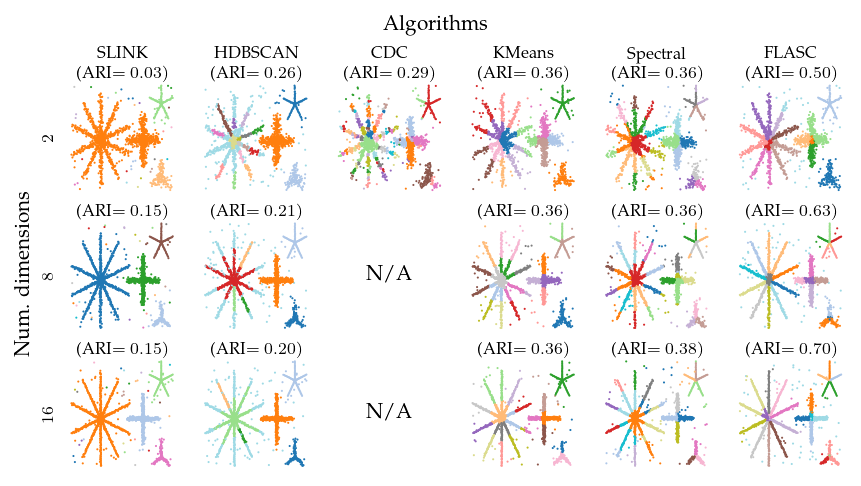

In [92]:
fig = sized_fig(1)
algs = ["slink", "hdbscan", "cdc", "kmeans", "spectral", "flasc"]
names = ["SLINK", "HDBSCAN", "CDC", "KMeans", "Spectral", "FLASC"]
cnt = 1
for d in result_df.d.unique():
    for alg, alg_name in zip(algs, names):
        plt.subplot(3, 6, cnt)
        plt.xticks([])
        plt.yticks([])
        plt.gca().spines["top"].set_visible(False)
        plt.gca().spines["right"].set_visible(False)
        plt.gca().spines["bottom"].set_visible(False)
        plt.gca().spines["left"].set_visible(False)
        cnt += 1
        row = best_cases.query("d == @d and alg == @alg")
        if row.shape[0] == 0:
            plt.text(0.5, 0.5, "N/A", fontsize=10, ha="center", va="center")
            continue
        if d == 2:
            plt.title(f"{alg_name}\n(ARI$={row.ari.iloc[0]:.2f})$", fontsize=8, y=0.92)
        else:
            plt.title(f"(ARI$={row.ari.iloc[0]:.2f})$", fontsize=8, y=0.92)

        plt.scatter(
            *np.load(
                f"data/generated/star_parameter_sweep_X_{row.repeat.iloc[0]}_{d}.npy"
            )[:, :2].T,
            s=1,
            c=row.labels.iloc[0] % 20,
            cmap="tab20",
            vmin=0,
            vmax=19,
            edgecolors="none",
            linewidths=0,
        )
        if alg == "slink":
            plt.ylabel(f"${d}$", fontsize=8)
plt.text(
    0,
    0.5,
    "Num. dimensions",
    rotation=90,
    fontsize=10,
    ha="center",
    va="center",
    transform=plt.gcf().transFigure,
)
plt.text(
    0.5,
    0.99,
    "Algorithms",
    fontsize=10,
    ha="center",
    va="center",
    transform=plt.gcf().transFigure,
)
plt.subplots_adjust(left=0.05, right=1, top=0.88)
plt.show()

#### ARI over parameters

Now, lets explore how sensitive the algorithms are to their parameters. The
other algorithms have ARI scores lower than 0.4 regardless of their parameters,
and there does not appear to be a trend indicating lower or higher values than
tested would improve their performance.

FLASC is most sensitive to the `min_samples` parameter, in particular with the
`core` approximation graph, which controls the level of connectivity used to
extract branches. The more edges are included, the shorter branches are in the
graph, leading to a lower branch detection sensitivity. The `min_cluster_size`
and `min_branch_size` parameters show a different trend. Once their value is
large enough to exclude noise, performance remains stable for a longer value
range. The optimal combination of these parameters is only visible when looking
at the maximum ARI instead of the average ARI shown in the plots.

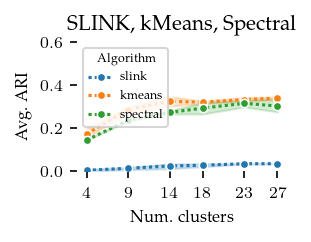

In [11]:
sized_fig(0.33)
sns.lineplot(
    result_df[~np.isnan(result_df.n_clusters)].query("d==2"),
    x="n_clusters",
    y="ari",
    hue="alg",
    dashes=(1, 1),
    marker="o",
    markersize=4,
)
plt.legend(title="Algorithm", handletextpad=0.5)
plt.xticks(n_clusters)
plt.ylim(0, 0.6)
plt.xlabel("Num. clusters")
plt.ylabel("Avg. ARI")
plt.title("SLINK, kMeans, Spectral")
plt.show()

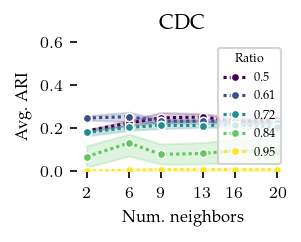

In [12]:
sized_fig(0.33)
sns.lineplot(
    result_df.query('d == 2 and alg == "cdc"'),
    x="k",
    y="ari",
    hue="ratio",
    dashes=(1, 1),
    markersize=4,
    marker="o",
    palette="viridis",
)

plt.title("CDC")

plt.legend(title="Ratio", handletextpad=0.5, loc="upper right")

plt.xticks(n_neighbors)
plt.xlabel("Num. neighbors")
plt.ylabel("Avg. ARI")

plt.ylim(0, 0.6)

plt.show()

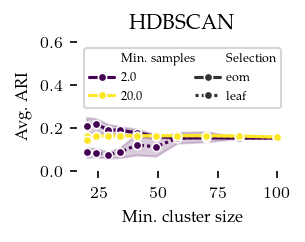

In [13]:
samples = [2, 20]
sized_fig(0.33)
sns.lineplot(
    result_df.query("d == 2 and alg == 'hdbscan' and min_samples in @samples").rename(
        columns=dict(min_samples="Min. samples", cluster_selection_method="Selection")
    ),
    style="Selection",
    dashes=["", (1, 1)],
    marker="o",
    markersize=4,
    x="min_cluster_size",
    y="ari",
    hue="Min. samples",
    palette="viridis",
)
legend = plt.legend(ncols=2, columnspacing=0, handlelength=2, handletextpad=0.5)
plt.title("HDBSCAN")
plt.xlabel("Min. cluster size")
plt.ylabel("Avg. ARI")
plt.ylim(0, 0.6)
plt.show()

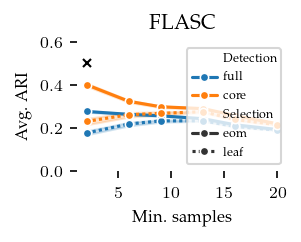

In [14]:
sized_fig(0.33)
sns.lineplot(
    result_df.query("d == 2 and alg=='flasc'").rename(
        columns=dict(
            cluster_selection_method="Selection",
            branch_detection_method="Detection",
        )
    ),
    style="Selection",
    dashes=["", (1, 1)],
    marker="o",
    markersize=4,
    x="min_samples",
    y="ari",
    hue="Detection",
    palette="tab10",
)
best = best_cases.query("d == 2 and alg == 'flasc'")
plt.plot(best.min_samples, best.ari, "x", color="black", markersize=4)
legend = plt.legend(
    columnspacing=0, handlelength=2, handletextpad=0.5, loc="upper right"
)
adjust_legend_subtitles(legend)
plt.title("FLASC")
plt.xlabel("Min. samples")
plt.ylabel("Avg. ARI")
plt.ylim(0, 0.6)
plt.show()

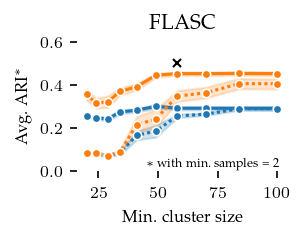

In [15]:
sized_fig(0.33)
sns.lineplot(
    result_df.query("d == 2 and alg=='flasc' and min_samples==2").rename(
        columns=dict(
            cluster_selection_method="Selection",
            branch_detection_method="Detection",
        )
    ),
    style="Selection",
    dashes=["", (1, 1)],
    marker="o",
    markersize=4,
    # errorbar=("pi", 50),
    x="min_cluster_size",
    y="ari",
    hue="Detection",
    palette="tab10",
    legend=False,
)
plt.plot(best.min_cluster_size, best.ari, "x", color="black", markersize=4)
adjust_legend_subtitles(legend)
plt.title("FLASC")
plt.xlabel("Min. cluster size")
plt.ylabel("Avg. ARI$^*$")
plt.text(
    0.875,
    0.11,
    "$*$ with min. samples = 2",
    fontsize=6,
    ha="right",
    va="bottom",
    transform=plt.gcf().transFigure,
)
plt.ylim(0, 0.6)
plt.show()

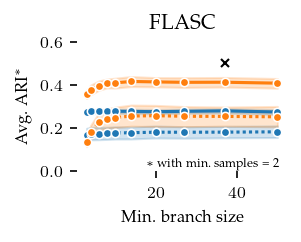

In [16]:
sized_fig(0.33)
sns.lineplot(
    result_df.query("d==2 and alg=='flasc' and min_samples==2").rename(
        columns=dict(
            cluster_selection_method="Selection",
            branch_detection_method="Detection",
        )
    ),
    style="Selection",
    dashes=["", (1, 1)],
    marker="o",
    markersize=4,
    # errorbar=("pi", 50),
    x="min_branch_size",
    y="ari",
    hue="Detection",
    palette="tab10",
    legend=False,
)
plt.plot(best.min_branch_size, best.ari, "x", color="black", markersize=4)
adjust_legend_subtitles(legend)
plt.title("FLASC")
plt.xlabel("Min. branch size")
plt.ylabel("Avg. ARI$^*$")
plt.text(
    0.875,
    0.11,
    "$*$ with min. samples = 2",
    fontsize=6,
    ha="right",
    va="bottom",
    transform=plt.gcf().transFigure,
)
plt.ylim(0, 0.6)
plt.show()

## Stability: Centroid spread

To show FLASC provides a stable result (in a practical sense), we visualize the
cluster centers it found across the five (random) generated datasets. This
demonstrates FLASC's output is similar across input samples drawn from the same
underlying distribution. Other algorithms, like k-means, do not have this
property!

In [65]:
from sklearn.metrics import pairwise_distances

centroids = {}
true_centroids = []
flasc_df = result_df.query("alg == 'flasc'").copy()
for r in tqdm(range(flasc_df.repeat.max() + 1)):
    for d in np.unique(flasc_df.d):
        X = np.load(f"data/generated/star_parameter_sweep_X_{r}_{d}.npy")
        y = np.load(f"data/generated/star_parameter_sweep_y_{r}_{d}.npy")

        true_centroid = [np.average(X[y == l], axis=0) for l in np.unique(y) if l != -1]
        true_centroids.append(dict(repeat=r, d=d, centroids=true_centroid))

        for index in flasc_df.query("d==@d and repeat==@r").index:
            labels = flasc_df.loc[index, "labels"]
            found_centroids = np.asarray(
                [
                    np.average(X[labels == l], axis=0)
                    for l in np.unique(labels)
                    if l != -1
                ]
            )
            closest_centroid = np.argmin(
                pairwise_distances(found_centroids, true_centroid), axis=0
            )
            points = found_centroids[closest_centroid]
            centralized_centroids = points - true_centroid
            spread = pairwise_distances(
                np.repeat(0.0, d)[None, :], centralized_centroids
            )[0, :]

            centroids[index] = dict(
                centroids=found_centroids,
                closest_centroid=found_centroids[closest_centroid],
                centralized_centroids=centralized_centroids,
                spread=spread,
            )

true_centroids = pd.DataFrame.from_records(true_centroids)
found_centroids = pd.DataFrame.from_records([*centroids.values()])
found_centroids.index = centroids.keys()
flasc_df = flasc_df.join(found_centroids)

100%|██████████| 5/5 [00:20<00:00,  4.02s/it]


In [66]:
spread = (
    flasc_df.groupby(
        by=[
            "d",
            "min_samples",
            "min_cluster_size",
            "min_branch_size",
            "branch_detection_method",
            "cluster_selection_method",
        ]
    )
    .agg(
        spread=pd.NamedAgg(column="spread", aggfunc=np.vstack),
        centroids=pd.NamedAgg(column="centroids", aggfunc=np.vstack),
        closest_centroid=pd.NamedAgg(column="closest_centroid", aggfunc=np.vstack),
    )
    .reset_index()
)
spread["percentile_95"] = spread.spread.apply(lambda x: np.percentile(x, 95))

### Results

#### Detected spread

The figure below shows the closest detected centroid (coloured dots) to each
ground-truth centroid (black cross) for all five input datasets. Generally, the
detected centroids spread around the ground truth centroids, staying within the
branch they belong to.

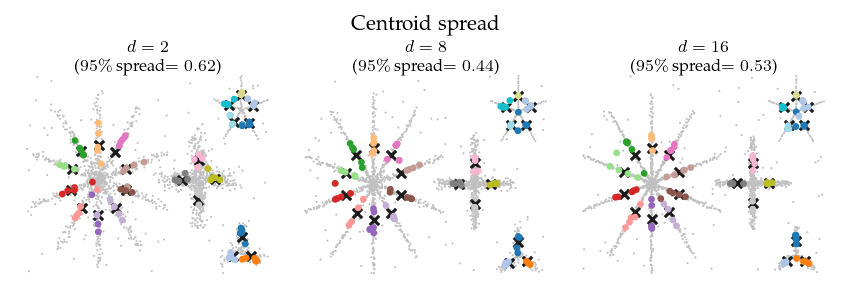

In [91]:
fig = sized_fig(1, aspect=0.33)

for cnt, d in enumerate(result_df.d.unique()):
    X = np.load(f"data/generated/star_parameter_sweep_X_0_{d}.npy")
    truths = np.asarray(
        true_centroids.query("d == @d and repeat == 0").centroids.iloc[0]
    )

    plt.subplot(1, 3, cnt + 1)
    plt.xticks([])
    plt.yticks([])
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["bottom"].set_visible(False)
    plt.gca().spines["left"].set_visible(False)

    row = spread.query("d == @d")

    plt.title(
        f"$d={d}$\n($95\%$ spread$={row.percentile_95.iloc[0]:.2f}$)",
        fontsize=8,
        y=0.92,
    )

    centroid = row.closest_centroid.iloc[0][:, :2]
    plt.scatter(*X[:, :2].T, s=1, color="silver", edgecolors="none", linewidths=0)
    plt.scatter(*truths[:, :2].T, s=20, color="k", marker="x")
    plt.scatter(
        *centroid.T,
        s=5,
        c=[i % 20 for _ in range(5) for i in range(truths.shape[0])],
        marker="o",
        cmap="tab20",
        vmin=0,
        vmax=19,
    )
plt.suptitle("Centroid spread", fontsize=10, y=0.99)
plt.subplots_adjust(left=0, right=1, top=0.8, bottom=0, wspace=0.05)
plt.show()

#### Spread over parameters

The distances between these closest detected centroids and their corresponding
ground truth centroid can also be used to explore parameter sensitive. Here, we
show the 95th percentile distance over true centroids across all five repeats.
Lower values are better. The parameters show approximately the same pattern as
with the ARI. Note that this measure is too optimistic when FLASC finds more
than the true number of subgroups.

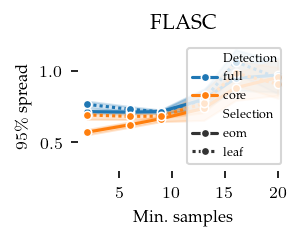

In [22]:
sized_fig(0.33)
sns.lineplot(
    spread.query("d == 2").rename(
        columns=dict(
            cluster_selection_method="Selection",
            branch_detection_method="Detection",
        )
    ),
    style="Selection",
    dashes=["", (1, 1)],
    marker="o",
    markersize=4,
    x="min_samples",
    y="percentile_95",
    hue="Detection",
    hue_order=["full", "core"],
    palette="tab10",
)
legend = plt.legend(
    columnspacing=0, handlelength=2, handletextpad=0.5, loc="upper right"
)
adjust_legend_subtitles(legend)
plt.title("FLASC")
plt.xlabel("Min. samples")
plt.ylabel("$95\%$ spread")
ylim = [0.3, 1.2]
plt.ylim(ylim)
plt.show()

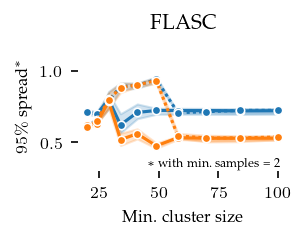

In [23]:
sized_fig(0.33)
sns.lineplot(
    spread.query("d == 2 and min_samples==2").rename(
        columns=dict(
            cluster_selection_method="Selection",
            branch_detection_method="Detection",
        )
    ),
    style="Selection",
    dashes=["", (1, 1)],
    marker="o",
    markersize=4,
    # errorbar=("pi", 50),
    x="min_cluster_size",
    y="percentile_95",
    hue="Detection",
    hue_order=["full", "core"],
    palette="tab10",
    legend=False,
)
adjust_legend_subtitles(legend)
plt.title("FLASC")
plt.xlabel("Min. cluster size")
plt.ylabel("$95\%$ spread$^*$")
plt.text(
    0.875,
    0.11,
    "$*$ with min. samples = 2",
    fontsize=6,
    ha="right",
    va="bottom",
    transform=plt.gcf().transFigure,
)
plt.ylim(ylim)
plt.show()

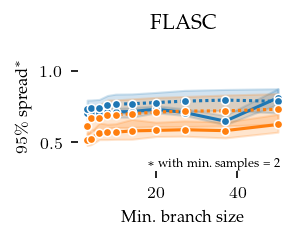

In [24]:
sized_fig(0.33)
sns.lineplot(
    spread.query("d==2 and min_samples==2").rename(
        columns=dict(
            cluster_selection_method="Selection",
            branch_detection_method="Detection",
        )
    ),
    style="Selection",
    dashes=["", (1, 1)],
    marker="o",
    markersize=4,
    # errorbar=("pi", 50),
    x="min_branch_size",
    y="percentile_95",
    hue="Detection",
    hue_order=["full", "core"],
    palette="tab10",
    legend=False,
)
adjust_legend_subtitles(legend)
plt.title("FLASC")
plt.xlabel("Min. branch size")
plt.ylabel("$95\%$ spread$^*$")
plt.text(
    0.875,
    0.11,
    "$*$ with min. samples = 2",
    fontsize=6,
    ha="right",
    va="bottom",
    transform=plt.gcf().transFigure,
)
plt.ylim(ylim)
plt.show()

## Compute time

Finally, lets explore compute times. Here, we show that FLASC is a fairly
inexpensive post-processing step on top of HDBSCAN, making it feasible for
practical use on large datasets. The algorithms are evaluated with known-good
parameters, either filling in the ground-truth number of clusters or using the
best values found in the parameter sweep. The number of points and dimensions
are varied to show how the algorithms behave with different types of data, by
tiling the stars dataset to create larger dataset.

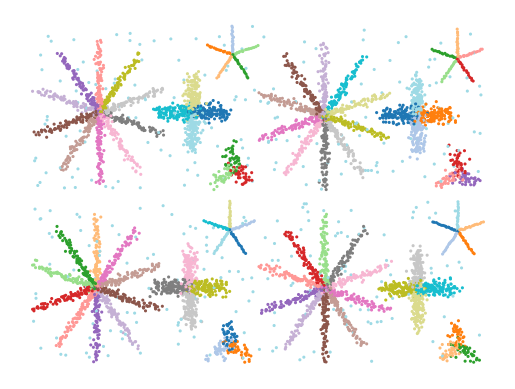

In [124]:
def tile_stars_dataset(rows=2, size_factor=1, num_dimensions=2):
    max_x = 8.5
    max_y = 6
    max_l = 0

    Xs = []
    ys = []
    for idx in range(rows * rows):
        X, y = make_stars_dataset(
            size_factor=size_factor, num_dimensions=num_dimensions
        )
        X[:, :2] += np.array(
            [
                [
                    ((idx % rows) * max_x) - X[:, 0].min(),
                    ((idx // rows) * max_y) - X[:, 1].min(),
                ]
            ]
        )
        y = np.where(y != -1, y + max_l, -1)
        max_l = y.max() + 1
        Xs.append(X)
        ys.append(y)
    return np.concatenate(Xs), np.concatenate(ys)


X, y = tile_stars_dataset(rows=2, size_factor=1, num_dimensions=2)
plt.scatter(*X.T, c=y % 20, **plot_kwargs)
plt.axis("off")
plt.show()

In [232]:
# Create output structure
from tqdm.contrib.itertools import product

timeout = 10 # seconds
dims = [2]  # , 8, 16]
results = {
    "repeat": [],
    "d": [],
    "rows": [],
    "n_points": [],
    "alg": [],
    "ari": [],
    "time": [],
    "labels": [],
}
active_algorithms = {d: algorithms.copy() for d in dims}

rows = 1
while active_algorithms:
    remove_next = {d: set() for d in dims}
    for r, d in product(range(5), dims, leave=False):
        if d not in active_algorithms:
            continue

        # Generate dataset
        X, y = tile_stars_dataset(rows=rows, size_factor=1, num_dimensions=d)
        np.save(f"data/generated/star_compute_time_X_{r}_{d}_{rows}", X)
        np.save(f"data/generated/star_compute_time_y_{r}_{d}_{rows}", y)

        # Run the parameter sweep
        for alg_name, alg_class in active_algorithms[d].items():
            if alg_name == "cdc" and d > 2:
                continue

            kwargs = static_params[alg_name]
            if alg_name in ["slink", "kmeans", "spectral"]:
                params = dict(n_clusters=len(set(y)))
            else:
                params = (
                    best_cases.query("d == @d and alg == @alg_name")
                    .dropna(axis=1)
                    .drop(columns=["repeat", "d", "alg", "ari", "labels"])
                    .to_dict("records")[0]
                )
                if alg_name == "flasc":
                    params["branch_selection_method"] = params[
                        "cluster_selection_method"
                    ]
                for param in [
                    "min_samples",
                    "min_cluster_size",
                    "min_branch_size",
                    "k",
                ]:
                    if param in params:
                        params[param] = int(params[param])

            start_time = time.perf_counter()
            cc = alg_class(**kwargs, **params)
            labels = cc.fit_predict(X)
            if alg_name == "flasc":
                labels = update_labels_with_branch_centrality(
                    cc, branch_centrality_vectors(cc)
                )[0]
            end_time = time.perf_counter()

            if (end_time - start_time) > timeout:
                remove_next[d].add(alg_name)

            results["repeat"].append(r)
            results["d"].append(d)
            results["rows"].append(rows)
            results["n_points"].append(X.shape[0])
            results["alg"].append(alg_name)
            results["ari"].append(adjusted_rand_score(y, labels))
            results["time"].append(end_time - start_time)
            results["labels"].append(labels)

    for d, algs in remove_next.items():
        for alg_name in algs:
            del active_algorithms[d][alg_name]
        if algs and not active_algorithms[d]:
            del active_algorithms[d]
    rows += 1

# Store the results!
time_df = pd.DataFrame.from_dict(results)
time_df.to_parquet("data/generated/star_compute_time_results.parquet")

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

### Results

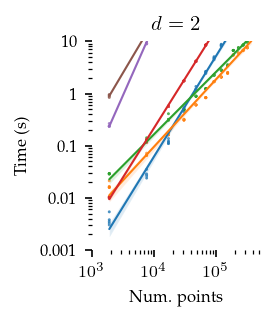

In [236]:
from matplotlib.lines import Line2D
from matplotlib.ticker import FixedLocator

sized_fig(1, 0.33)
palette = plt.cm.tab10.colors
alg_names = ["kmeans", "hdbscan", "flasc", "slink", "spectral", "cdc"]
for i, d in enumerate(dims):
    plt.subplot(1, 3, i + 1)
    for j, alg in enumerate(alg_names):
        data = time_df.query("d == @d and alg == @alg")
        sns.regplot(
            x=np.log10(data["n_points"]),
            y=np.log10(data["time"]),
            units=data["repeat"],
            order=1,
            ci=95,
            scatter_kws=dict(linewidths=0, s=2, edgecolor="none", facecolor=palette[j]),
            line_kws=dict(linewidth=1, color=palette[j]),
        )
    if 1 == 0:
        adjust_legend_subtitles(
            plt.legend(
                handles=[
                    Line2D([], [], color=palette[j], label=k)
                    for j, k in enumerate(alg_names)
                ],
                labelspacing=0.1,
            ),
        )

    plt.ylim(-3, 1)
    y_ticks = np.arange(-3, 2)
    plt.gca().set_yticks(y_ticks)
    if i > 0:
        plt.gca().get_yaxis().set_major_formatter(lambda x, pos: "")
    else:
        plt.gca().get_yaxis().set_major_formatter(lambda x, pos: f"{10.0 ** x:g}")
    plt.gca().get_yaxis().set_minor_locator(
        FixedLocator(
            locs=np.concat(
                (
                    np.log10(np.arange(2, 10) * 10.0 ** (y_ticks[0] - 1)),
                    np.log10(np.arange(2, 10) * 10.0 ** y_ticks[None].T).ravel(),
                )
            )
        )
    )

    x_ticks = np.arange(3, 6, 1)
    plt.xlim(3, 5.7)
    plt.gca().set_xticks(x_ticks)
    plt.gca().get_xaxis().set_major_formatter(lambda x, pos: "$10^{" + f"{x:d}" + "}$")
    plt.gca().get_xaxis().set_minor_locator(
        FixedLocator(
            locs=np.concat(
                (
                    np.log10(np.arange(2, 10) * 10.0 ** (x_ticks[0] - 1)),
                    np.log10(np.arange(2, 10) * 10.0 ** x_ticks[None].T).ravel(),
                )
            )
        )
    )

    plt.ylabel("Time (s)" if i == 0 else "")
    plt.xlabel("Num. points")
    plt.title(f"$d={d}$")
plt.subplot(1, 3, 1)
plt.subplots_adjust(wspace=0.4)
plt.show()